# Time explicit LCA with a dummy foreground and premise background


In [1]:
import numpy as np
import bw2data as bd
import bw2calc as bc
import bw2io as bi
from bw_temporalis import TemporalDistribution
from timex_lca import TimexLCA

In [2]:
PROJECT_NAME = "bw25_premise_background_v2"
RESET = False

if PROJECT_NAME in bd.projects and not RESET:  # use existing project
    print("Using existing project: {}".format(PROJECT_NAME))
    bd.projects.set_current(PROJECT_NAME)

else:  # create project from scratch
    print("Creating new project: {}".format(PROJECT_NAME))
    if PROJECT_NAME in bd.projects:
        bd.projects.delete_project(PROJECT_NAME)
    bi.backup.restore_project_directory(
        r"filepath/to/backup/directory"
    )  # tar file shared on slack
    bd.projects.set_current(PROJECT_NAME)

Using existing project: bw25_premise_background_v2


In [3]:
# prospective databases were generated with premise, updating only electricity
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

Flow chart of system:<br> <br> 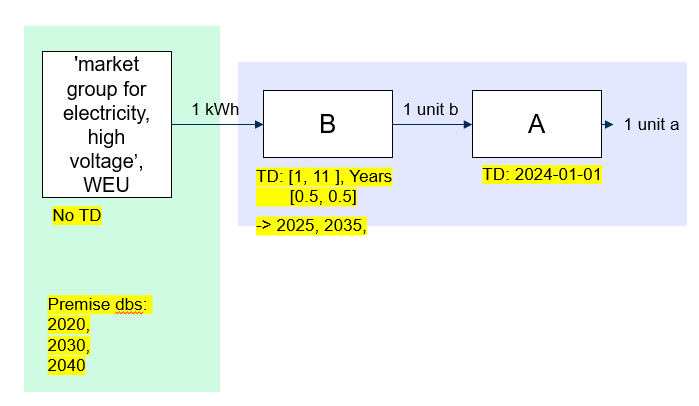
<br> <br>


Select electricity process in dbs


In [4]:
# selecting Western Europe's electricity market mix as
electr_WEU_2020 = [
    x
    for x in db_2020
    if (
        x["name"] == "market group for electricity, high voltage"
        and "period" not in x["name"]
        and x["location"] == "WEU"
    )
][0]
electr_WEU_2020

'market group for electricity, high voltage' (kilowatt hour, WEU, None)

In [5]:
electr_WEU_2030 = [
    x
    for x in db_2030
    if (
        x["name"] == "market group for electricity, high voltage"
        and "period" not in x["name"]
        and x["location"] == "WEU"
    )
][0]

electr_WEU_2040 = [
    x
    for x in db_2040
    if (
        x["name"] == "market group for electricity, high voltage"
        and "period" not in x["name"]
        and x["location"] == "WEU"
    )
][0]

write foreground db:


In [6]:
bd.Database("foreground").write(
    {
        ("foreground", "A"): {
            "name": "process A",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("foreground", "A"),
                },
                {
                    "amount": 1,
                    "type": "technosphere",
                    "input": ("foreground", "B"),
                    "temporal_distribution": TemporalDistribution(
                        np.array([1, 11], dtype="timedelta64[Y]"), np.array([0.5, 0.5])
                    ),
                },
            ],
        },
        ("foreground", "B"): {
            "name": "process B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("foreground", "B"),
                },
                {
                    "amount": 1,
                    "type": "technosphere",
                    "input": electr_WEU_2020.key,  # market group for electricity, high voltage' (kilowatt hour, WEU, None)
                }
            ],
        },
    }
)

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 8577.31it/s]

Vacuuming database 


select method:


In [7]:
method = (
    "IPCC 2021 no LT",
    "climate change no LT",
    "global warming potential (GWP100) no LT",
)

### Standard Timex LCA from here on:


In [8]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [9]:
demand = {("foreground", "A"): 1}

In [10]:
tlca = TimexLCA(
    demand, method, None, database_date_dict
)

Calculation count: 2


In [11]:
tlca.build_timeline()

,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,2024,98287,2024-01-01,98285,process A,2024,-1,2024-01-01,-1,-1,1.0,"{'db_2020': 0.6000547495209416, 'db_2030': 0.3..."
1,2025,98288,2025-01-01,98286,process B,2024,98287,2024-01-01,98285,process A,0.5,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
2,2025,98289,2025-01-01,49780,"market group for electricity, high voltage",2025,98288,2025-01-01,98286,process B,1.0,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
3,2035,98290,2035-01-01,98286,process B,2024,98287,2024-01-01,98285,process A,0.5,"{'db_2030': 0.5, 'db_2040': 0.5}"
4,2035,98291,2035-01-01,49780,"market group for electricity, high voltage",2035,98290,2035-01-01,98286,process B,1.0,"{'db_2030': 0.5, 'db_2040': 0.5}"


In [13]:
tlca.node_id_collection_dict['first_level_background_node_ids_all']

{49780, 73885, 97990}

In [14]:
tlca.biosphere_time_mapping_dict

{}

In [15]:
tlca.build_datapackage()

In [16]:
tlca.lci()

In [17]:
tlca.lcia()

In [18]:
print("Old static LCA Score:", tlca.static_lca.score)
print("New Timex LCA Score:", tlca.score)

Old static LCA Score: 0.3457984665944551
New MEDUSA LCA Score: 0.1418399100528639


In [19]:
tlca.create_labelled_dynamic_biosphere_dataframe()

,"((db_2020, 0000845fede810c891788763310005db), 2020)","((db_2020, 000246fec6ba3180d44719c8a58f94ee), 2020)","((db_2020, 0002bb27891915b306bed66b596f4345), 2020)","((db_2020, 000443ca0743c972594a6236c29ac4c7), 2020)","((db_2020, 000860bc617c5e3ce369f5736abbfab1), 2020)","((db_2020, 00111b793f3b554d6976e765c9272b39), 2020)","((db_2020, 0012da481fe8d7533ec8584362469d16), 2020)","((db_2020, 001974f7bfeddf21e6642b3344948da1), 2020)","((db_2020, 001bfd4d97e6088bd288a652ca92da5c), 2020)","((db_2020, 001c48b2b858bc3088ece60e3828d235), 2020)",...,"((db_2040, 77f898b7918c43b5af82c4f8482f8b55), 2040)","((db_2040, 1975ca20825842679b68513a45a8caa4), 2040)","((db_2040, 26dd3964801b4af1b7dde1502a91dd22), 2040)","((foreground, A), dynamic)","((foreground, B), dynamic)","((foreground, A), 2024)","((foreground, B), 2025)","((db_2020, 1f33f55054bc46649825290aaf681b78), 2025)","((foreground, B), 2035)","((db_2020, 1f33f55054bc46649825290aaf681b78), 2035)"
"(38a622c6-f086-4763-a952-7c6b3b1c42ba, 2020-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(541a823c-0aad-4dc4-9123-d4af4647d942, 2020-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(8cbaa905-41b0-4327-8403-bf1c8eb25429, 2020-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(f681eb3c-854a-4f78-bcfe-76dfbcf9df3c, 2020-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(a0fec60d-3f74-48bf-a2d2-58c30fc13e53, 2020-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(ddd99a3a-be86-423d-b36a-a9dc8af1b1f8, 2040-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(21e46cb8-6233-4c99-bac3-c41d2ab99498, 2040-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(295c9740-6fdb-4676-9eb8-15e3786f713d, 2040-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(5716c728-bd33-414d-8691-16e5534f5d37, 2040-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
co2 = bd.get_node(id=1168)

In [21]:
co2['code']

'aa7cac3a-3625-41d4-bc54-33e2cf11ec46'

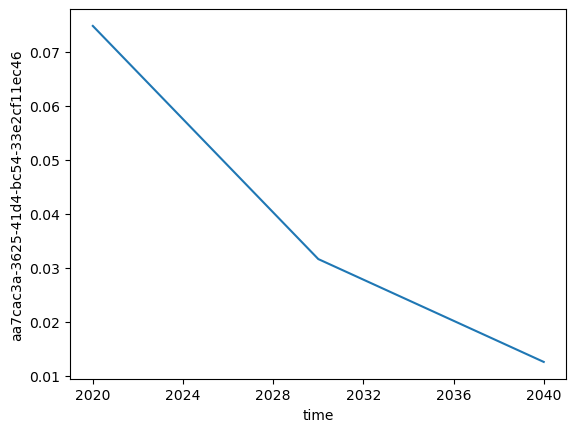

In [22]:
tlca.plot_dynamic_inventory(co2['code'])

compare with prospective-dynamic score with expected results


In [17]:
# compare with expected results: tiny deviation is fine!

# expected lca results from 1 kWh electricty WEU 2020
lca_electr_WEU_2020 = bc.LCA(
    {(electr_WEU_2020["database"], electr_WEU_2020["code"]): 1}, method
)
lca_electr_WEU_2020.lci()
lca_electr_WEU_2020.lcia()
score_2020 = lca_electr_WEU_2020.score

# expected lca results from 1 kWh electricty WEU 2030
lca_electr_WEU_2030 = bc.LCA(
    {(electr_WEU_2030["database"], electr_WEU_2030["code"]): 1}, method
)
lca_electr_WEU_2030.lci()
lca_electr_WEU_2030.lcia()
score_2030 = lca_electr_WEU_2030.score

# expected lca results from 1 kWh electricty WEU 2040
lca_electr_WEU_2040 = bc.LCA(
    {(electr_WEU_2040["database"], electr_WEU_2040["code"]): 1}, method
)
lca_electr_WEU_2040.lci()
lca_electr_WEU_2040.lcia()
score_2040 = lca_electr_WEU_2040.score

# expected score according to temporal distributions
expected_score = 0.5 * (0.5 * score_2020 + 0.5 * score_2030) + 0.5 * (
    0.5 * score_2030 + 0.5 * score_2040
)
delta = expected_score - tlca.score
print(f"Difference between Timex score and expected score {delta}")

Difference between medusa score and expected score 1.7552186933167402e-05
